In [1]:
import kagglehub
import os
import pandas as pd
import re
from textblob import TextBlob
from pymongo import MongoClient
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# 1. Load Twitter Data
def load_data(file_path):
    
    data = pd.read_csv(file_path, encoding='ISO-8859-1', header=None)
    
    # Rename columns based on the dataset structure
    data.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']
    return data

def clean_text(text):
    if not isinstance(text, str):  # Check if the input is not a string
        return ""  # Return an empty string for non-string values
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions (@user) and hashtags
    text = re.sub(r'@\w+|#', '', text)
    # Remove special characters, numbers, and punctuations
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # Convert to lowercase
    text = text.lower()
    return text
    
# 3. Tokenization and Stopword Removal
def preprocess_text(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)


# 4. Sentiment Analysis
def analyze_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

def prepare_data_for_mongodb(data):
    # Ensure 'text' column exists and handle non-string values
    if 'text' not in data.columns:
        raise KeyError("The dataset does not contain a 'text' column.")
    
    # Add new columns for cleaned text and sentiment
    data['cleaned_text'] = data['text'].apply(clean_text).apply(preprocess_text)
    data['sentiment'] = data['cleaned_text'].apply(analyze_sentiment)
    
    # Convert DataFrame to a list of dictionaries
    records = data.to_dict(orient='records')
    return records

def preprocess_twitter_dates(date_series):
    def convert_twitter_date(date_str):
        if not isinstance(date_str, str):  # Ensure the value is a string
            return None
        try:
            # Parse the Twitter date format
            return datetime.strptime(date_str.replace(" PDT", ""), "%a %b %d %H:%M:%S %Y").strftime("%Y-%m-%d")
        except ValueError:
            print(f"Invalid date format: {date_str}")  # Log the invalid date
            return None  # Return None for invalid formats
    return date_series.apply(convert_twitter_date)

# 6. Insert Data into MongoDB
def insert_into_mongodb(records, db_name, collection_name):
    # Convert DataFrame to a list of dictionaries if it's a DataFrame
    if isinstance(records, pd.DataFrame):
        records = records.to_dict(orient='records')

    # Connect to MongoDB
    client = MongoClient("mongodb://localhost:27017/")
    db = client[db_name]
    collection = db[collection_name]

    # Insert records
    collection.insert_many(records)
    print(f"Inserted {len(records)} records into the '{collection_name}' collection in the '{db_name}' database.")

def sentiment_trends_over_time(data):
    # Convert date column to datetime
    data['date'] = pd.to_datetime(data['date'])
    # Group by date and sentiment
    trends = data.groupby([data['date'].dt.date, 'sentiment']).size().unstack(fill_value=0)
    trends.plot(kind='line', figsize=(10, 6))
    plt.title("Sentiment Trends Over Time")
    plt.xlabel("Date")
    plt.ylabel("Number of Tweets")
    plt.legend(title="Sentiment")
    plt.show()

def sentiment_by_category(data, keywords):
    # Initialize a dictionary for category sentiment counts
    category_sentiments = {keyword: {'positive': 0, 'negative': 0, 'neutral': 0} for keyword in keywords}
    
    for index, row in data.iterrows():
        text = row.get('text', '')  # Default to an empty string if 'text' is missing
        if not isinstance(text, str):  # Check if the text is not a string
            continue  # Skip this row if the text is not a valid string
        
        text = text.lower()  # Convert text to lowercase
        sentiment = row.get('sentiment', 'neutral')  # Default to 'neutral' if sentiment is missing
        
        for keyword in keywords:
            if keyword in text:
                if sentiment == 0:
                    category_sentiments[keyword]['negative'] += 1
                elif sentiment == 4:
                    category_sentiments[keyword]['positive'] += 1
                else:
                    category_sentiments[keyword]['neutral'] += 1
    
    # Convert results to DataFrame for visualization
    category_df = pd.DataFrame(category_sentiments).T
    category_df.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title("Sentiment by Product Categories")
    plt.xlabel("Category")
    plt.ylabel("Number of Tweets")
    plt.legend(title="Sentiment")
    plt.show()

def sentiment_vs_activity_correlation(data):
    # Convert date column to datetime
    data['date'] = pd.to_datetime(data['date'])
    # Group by date
    tweet_counts = data.groupby(data['date'].dt.date).size()
    sentiment_counts = data.groupby([data['date'].dt.date, 'sentiment']).size().unstack(fill_value=0)
    sentiment_counts['total'] = sentiment_counts.sum(axis=1)
    
    # Plot correlation
    plt.scatter(tweet_counts, sentiment_counts['total'])
    plt.title("Correlation Between Tweet Activity and Sentiment")
    plt.xlabel("Tweet Volume")
    plt.ylabel("Sentiment Activity")
    plt.show()

def extract_topics(data, n_topics=10):
    # Extract text
    all_text = data['text'].dropna()
    vectorizer = CountVectorizer(max_features=1000, stop_words='english', ngram_range=(2, 3))
    X = vectorizer.fit_transform(all_text)
    # Get top n topics
    topic_counts = X.sum(axis=0).A1
    topics = [(word, topic_counts[idx]) for word, idx in vectorizer.vocabulary_.items()]
    topics = sorted(topics, key=lambda x: x[1], reverse=True)[:n_topics]
    
    # Convert to DataFrame for visualization
    topics_df = pd.DataFrame(topics, columns=["Phrase", "Frequency"])
    topics_df.plot(kind='bar', x='Phrase', y='Frequency', legend=False, color='teal')
    plt.title(f"Top {n_topics} Discussed Topics")
    plt.xlabel("Phrase")
    plt.ylabel("Frequency")
    plt.show()

def sentiment_by_user(data, top_n=10):
    # Get top users
    top_users = data['user'].value_counts().head(top_n).index
    user_sentiments = data[data['user'].isin(top_users)].groupby(['user', 'sentiment']).size().unstack(fill_value=0)
    
    # Plot
    user_sentiments.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(f"Sentiment by Top {top_n} Users")
    plt.xlabel("User")
    plt.ylabel("Number of Tweets")
    plt.legend(title="Sentiment")
    plt.show()

def count_spending_and_power_tweets(data, spending_keywords, power_keywords):
    # Initialize counters
    spending_count = 0
    power_count = 0

    for index, row in data.iterrows():
        # Safely retrieve text and ensure it is a string
        text = row.get('text', '')
        if not isinstance(text, str):
            continue  # Skip rows where text is not a string

        text = text.lower()  # Convert text to lowercase
        # Check if any keyword from each category is in the text
        if any(keyword in text for keyword in spending_keywords):
            spending_count += 1
        if any(keyword in text for keyword in power_keywords):
            power_count += 1

    print(f"Tweets mentioning spending habits: {spending_count}")
    print(f"Tweets mentioning purchasing power: {power_count}")

    # Plot results
    counts = {'Spending Habits': spending_count, 'Purchasing Power': power_count}
    plt.bar(counts.keys(), counts.values(), color=['blue', 'orange'])
    plt.title("Tweets Discussing Spending Habits and Purchasing Power")
    plt.xlabel("Category")
    plt.ylabel("Number of Tweets")
    plt.show()

def trends_in_keywords_over_time(data, spending_keywords, power_keywords, interval='D'):
    # Ensure 'date' is a datetime object
    if 'date' not in data.columns or data['date'].isnull().all():
        raise KeyError("The 'date' column is missing or invalid in the dataset.")
    data['date'] = pd.to_datetime(data['date'])

    # Initialize lists for counts
    spending_trend = []
    power_trend = []
    time_periods = []

    # Group data by the specified interval (e.g., daily)
    grouped = data.set_index('date').resample(interval)

    for period, group in grouped:
        # Combine all text for this period
        combined_text = ' '.join(group['text'].dropna().astype(str).str.lower())

        # Count keyword mentions for spending habits
        spending_count = sum(keyword in combined_text for keyword in spending_keywords)
        spending_trend.append(spending_count)

        # Count keyword mentions for purchasing power
        power_count = sum(keyword in combined_text for keyword in power_keywords)
        power_trend.append(power_count)

        # Record the time period
        time_periods.append(period)

    # Create a DataFrame for trends
    trends_df = pd.DataFrame({
        'Time Period': time_periods,
        'Spending Habits': spending_trend,
        'Purchasing Power': power_trend
    })

    # Plot trends
    trends_df.set_index('Time Period').plot(figsize=(12, 6))
    plt.title(f"Keyword Trends Over Time ({interval} Interval)")
    plt.xlabel("Time Period")
    plt.ylabel("Mentions")
    plt.legend(title="Category")
    plt.show()

    return trends_df


In [3]:
# Download latest version
tweets_path = kagglehub.dataset_download("kazanova/sentiment140")

print("Path to tweets dataset files:", tweets_path)

transaction_path = kagglehub.dataset_download("mathchi/online-retail-ii-data-set-from-ml-repository")

print("Path to transaction dataset files:", transaction_path)

directory_tweets_path = '/Users/panagiotapetropoulou/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2'
directory_transaction_path = '/Users/panagiotapetropoulou/.cache/kagglehub/datasets/mathchi/online-retail-ii-data-set-from-ml-repository/versions/3'
# List all files in the directory
tweets_files = os.listdir(directory_tweets_path)
transaction_files = os.listdir(directory_transaction_path)
print("Tweet files:", tweets_files)
print("Transaction files:", transaction_files)

Path to tweets dataset files: /Users/panagiotapetropoulou/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2
Path to transaction dataset files: /Users/panagiotapetropoulou/.cache/kagglehub/datasets/mathchi/online-retail-ii-data-set-from-ml-repository/versions/3
Tweet files: ['training.1600000.processed.noemoticon.csv']
Transaction files: ['Year 2010-2011.csv', 'online_retail_II.xlsx', 'Year 2009-2010.csv']


In [4]:
stop_words = set(stopwords.words('english'))

In [5]:
if __name__ == "__main__":
    # File paths
    tweets_file_path = os.path.join(tweets_path, "training.1600000.processed.noemoticon.csv")
    #transaction_file_path = os.path.join(transaction_path, "Year 2009-2010.csv")

    # Load datasets
    twitter_data = load_data(tweets_file_path)
    #transaction_data = pd.read_csv(transaction_file_path, encoding='ISO-8859-1')

    # Prepare tweets data
    prepared_records = prepare_data_for_mongodb(twitter_data)

    # MongoDB details
    db_name = "twitter_analysis"
    tweets_collection_name = "tweets"
    #transaction_collection_name = "transactions"
    combined_collection_name = "combined_data"

    # Insert data into MongoDB
    insert_into_mongodb(prepared_records, db_name, tweets_collection_name)
    #insert_into_mongodb(transaction_data, db_name, transaction_collection_name)

    # Combine datasets
    #combine_datasets(db_name, tweets_collection_name, transaction_collection_name, combined_collection_name)

    print("Data ingestion and combination complete.")

Inserted 1600000 records into the 'tweets' collection in the 'twitter_analysis' database.
Data ingestion and combination complete.


Connected to MongoDB. Retrieving data...


/var/folders/0s/9blpggvd5w394j_84y785pn80000gn/T/ipykernel_1486/2005817884.py:15: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  data['date'] = pd.to_datetime(data['date'])  # Ensure 'date' is datetime


Data Retrieved: 14562980 records found.

1. Sentiment Trends Over Time:


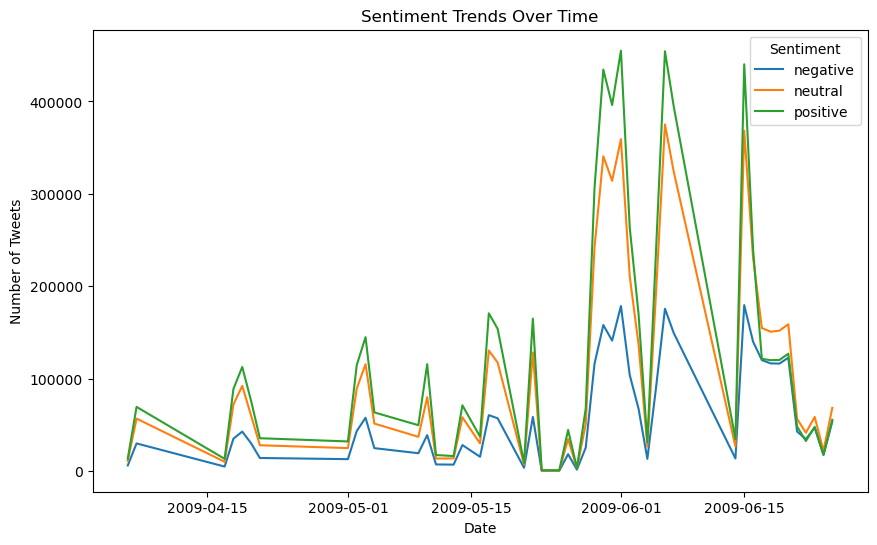


2. Sentiment by Product Categories:


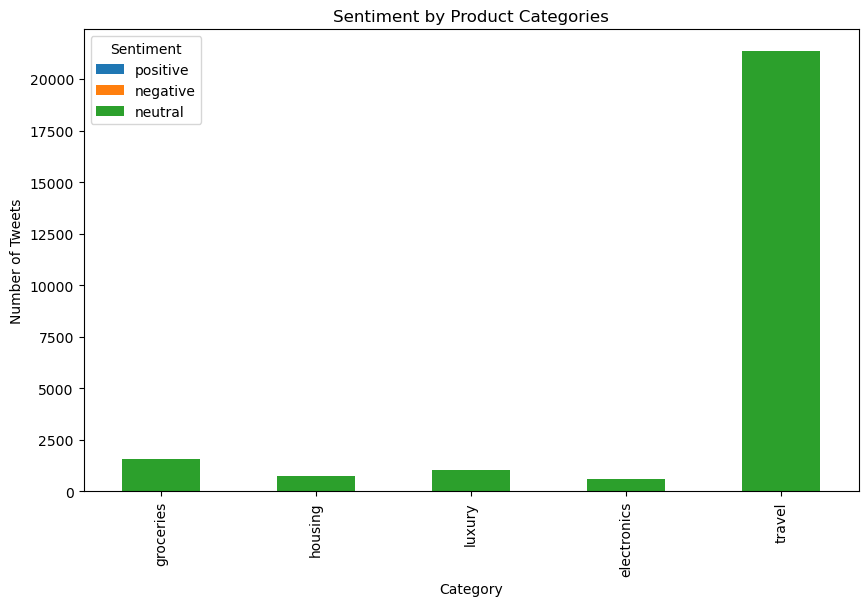


3. Correlation Between Sentiment and Activity:


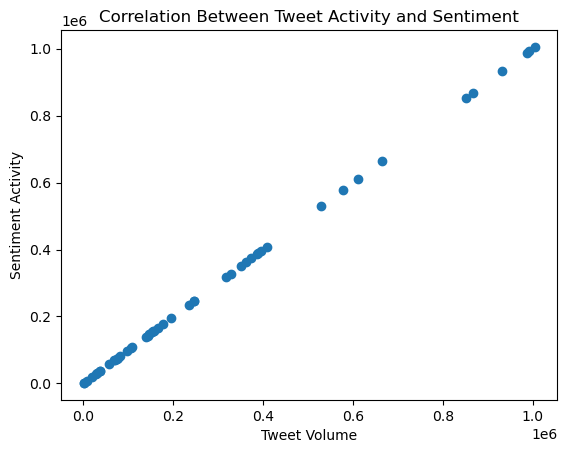


4. Most Discussed Topics:


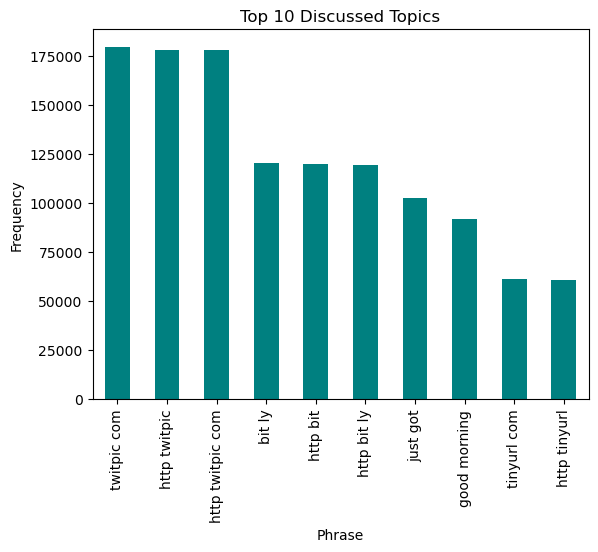


5. Sentiment by Top Users:


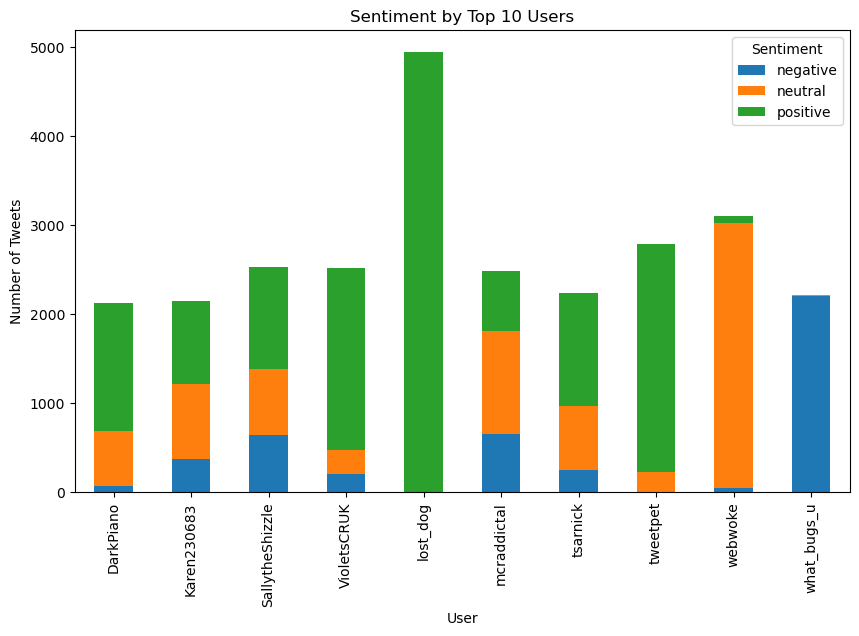

In [6]:
if __name__ == "__main__":
    # 1. Connect to MongoDB
    client = MongoClient("mongodb://localhost:27017/")  
    db = client["twitter_analysis"]  
    collection = db["tweets"]  

    print("Connected to MongoDB. Retrieving data...")

    # 2. Retrieve Data from MongoDB
    cursor = collection.find()  # Fetch all documents
    data = pd.DataFrame(list(cursor))  # Convert to pandas DataFrame

    # 3. Ensure data is properly structured
    if 'date' in data.columns:
        data['date'] = pd.to_datetime(data['date'])  # Ensure 'date' is datetime
    else:
        raise KeyError("No 'date' column found in the dataset.")
    print(f"Data Retrieved: {data.shape[0]} records found.")

    # 4. Perform Queries
    print("\n1. Sentiment Trends Over Time:")
    sentiment_trends_over_time(data)

    print("\n2. Sentiment by Product Categories:")
    keywords = ['groceries', 'housing', 'luxury', 'electronics', 'travel'] 
    sentiment_by_category(data, keywords)

    print("\n3. Correlation Between Sentiment and Activity:")
    sentiment_vs_activity_correlation(data)

    print("\n4. Most Discussed Topics:")
    extract_topics(data, n_topics=10)

    print("\n5. Sentiment by Top Users:")
    sentiment_by_user(data, top_n=10)


Tweets mentioning spending habits: 44586
Tweets mentioning purchasing power: 36549


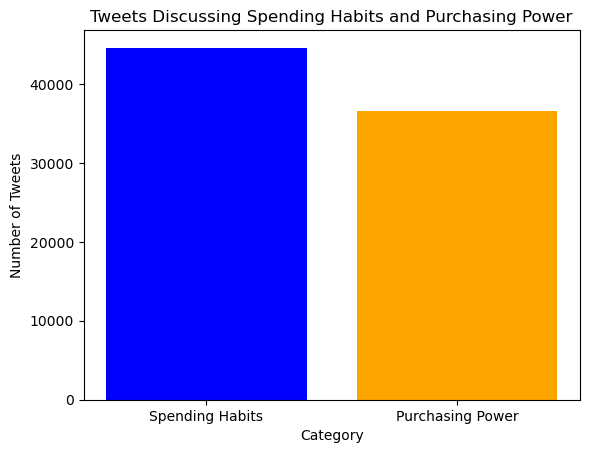

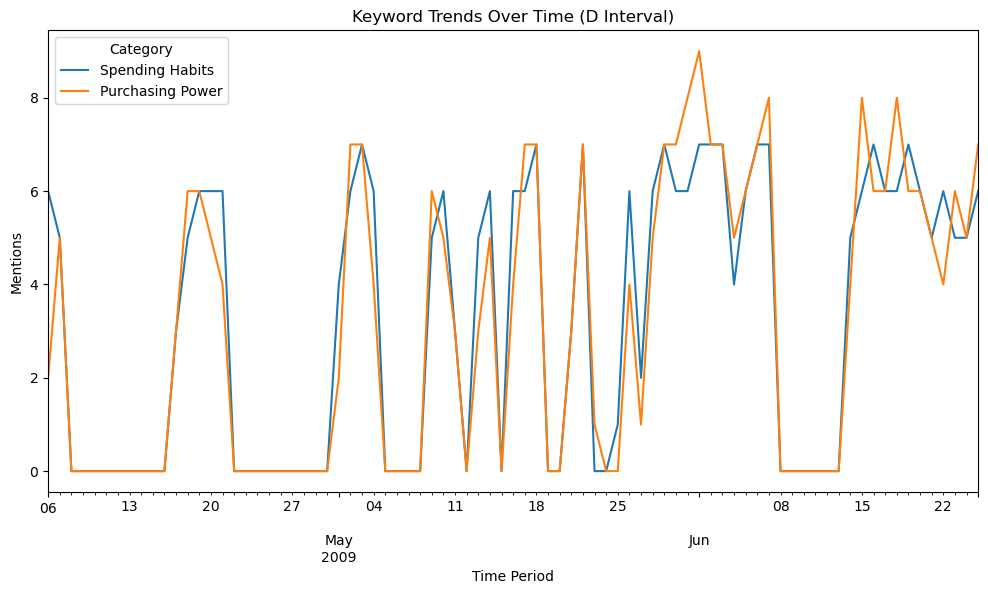

In [8]:
spending_keywords = ['spending', 'expenses', 'saving', 'budget', 'cutting', 'afford', 'reducing', 'over-budget']
power_keywords = ['purchasing', 'buying power', 'affordability', 'cost', 'prices', 'expensive', 'inflation', 'rising price', 
                  'overpriced', 'unaffordable', 'cant afford','too expensive']

count_spending_and_power_tweets(data, spending_keywords, power_keywords)
trends_df = trends_in_keywords_over_time(data, spending_keywords, power_keywords, interval='D')